## Inference over a planar robotic arm - edit
This model implements a state-space model for rigid body dynamics of the robotic arm.

Our state-space $\mathbf{x} \in \mathbb{R}^6 $ includes torques $\tau_i$, angles $\theta_i$ and angular velocities $\dot{\theta}_i$. We append all static parameters in $\phi = \{L_{1}, L_{2}, M_{1}, M_{2}\}$.

$$
\mathbf{x} = \begin{pmatrix} \mathbf{x}_1 = \tau_1 \\  \mathbf{x}_2 = \tau_2 \\ \mathbf{x}_3 =\theta_1 \\ \mathbf{x}_4 =\theta_2 \\
\mathbf{x}_5 = \dot{\theta}_1 \\ \mathbf{x}_6 = \dot{\theta}_2 \end{pmatrix}, \quad \mathbf{\dot{x}} = \begin{pmatrix} 0 \\  0 \\ \mathbf{x}_5 \\ \mathbf{x}_6 \\ \mathbf{D}^{-1}(\mathbf{x}_4, \phi) [\begin{pmatrix} \mathbf{x}_1 \\ \mathbf{x}_2 \end{pmatrix} - \mathbf{c}(\mathbf{x}_3, \mathbf{x}_4) -\mathbf{h}(\mathbf{x}_4, \mathbf{x}_5, \mathbf{x}_6) ]
\end{pmatrix}  := a(\mathbf{x})
$$

Where $\mathbf{D} \in \mathbb{R}^{2 \times 2}$ is the inertia tensor and $\mathbf{c},\mathbf{h} \in \mathbb{R}^{2}$ are gravity and fictitious forces vectors, respectively.

Note that $a(\mathbf{x})$ is non-linear because (1) the operation $\mathbf{D}^{-1}(\mathbf{x}_4, \phi) \begin{pmatrix} \mathbf{x}_1 \\ \mathbf{x}_2 \end{pmatrix}$, and (2) $\mathbf{c},\mathbf{h}$ are non-linear functions of the state.

with noise on the torque

$$
\mathbf{\dot{x}} = a(\mathbf{x}) + \begin{pmatrix} 1 \\ 1 \\ 0 \\ 0\\0\\0\end{pmatrix} \nu, \quad \nu \sim \mathcal{N}(0,1)
$$

with Euler discretizetion 

$$
\mathbf{x}_{t+\Delta{t}} = \mathbf{x}_t + \Delta{t}a(\mathbf{x}_t) + \begin{pmatrix} \Delta{t} \\ \Delta{t} \\ 0 \\ 0 \\ 0 \\0 \end{pmatrix} \nu_t \approx \mathbf{x}_t + \Delta{t}a(\mathbf{x}_t) + \begin{pmatrix} \Delta{t} \\ \Delta{t} \\ \sigma \\ \sigma \\ \sigma \\\sigma \end{pmatrix} \nu_t
 $$

where we introduce $\sigma<<\Delta{t}$ to avoid a degenerate distribution.
So our transition is defined as follows:

$$
f(\mathbf{x}_{t+\Delta{t}}|\mathbf{x}_t) = \mathcal{N}(\mathbf{x}_t + \Delta{t}a(\mathbf{x}_t), \text{diag}(\Delta{t}^2,\Delta{t}^2, \sigma, \sigma, \sigma, \sigma))
$$

The emission is 

$$
g(\mathbf{y}_t | \mathbf{x}_t) = \text{FW-KIN}(\mathbf{x}_3, \mathbf{x}_4)
$$

## Concepts Explored in this notebook
The full model from torques to coordinates $\mathbf{\tau} \rightarrow \mathbf{y}$ can be estimated properly with enough independent SMC samplers. In this implementation, the batch dimension of each tensor is used as an independent SMC sampler.

For parameter learning $\theta : = \{M_1, M_2, L_1, L_2\}$, we do not need to use SMC samplers; `batch_size` could be small, even 1. in each SGD iteration, I estimate the states $\mathbf{x}$. Some SGD iterations will be good and some bad, but we assume that they're good enough. Then, offline, we use many independent particle filters.

In [1]:
import os
print(os.getcwd())
plot_folder = 'planar_arm_dyn_plots'

/Users/danbiderman/Dropbox/Columbia/1.Dan/John/aesmc/test


In [2]:
# change dir to import from aesmc
os.chdir("/Users/danbiderman/Dropbox/Columbia/1.Dan/John/aesmc")
import aesmc.statistics as statistics
import aesmc.inference as inference
import aesmc.train as train
import aesmc.losses as losses
import aesmc.state as state
import aesmc.math as math
import aesmc.smoothing as smoothing

In [3]:
# change dir to import from aesmc/test
os.chdir("/Users/danbiderman/Dropbox/Columbia/1.Dan/John/aesmc/test")
from arm_models import planar_arm_dyn_model # the model script -- distribution objects are defined there
from arm_models import arm_utils # make video, plot post, params to coords
from arm_models import utils_summary
from arm_models import fw_sim_planar_arm_dyn

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

In [5]:
# matplotlib general settings 
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

mpl.rcParams['lines.linewidth'] = 4.0

In [6]:
import pickle

# pickle utils
def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

def load_object(filename):
    with open(filename, 'rb') as input:  # note rb and not wb
        return pickle.load(input)

In [7]:
def sim_data_from_model(model_dict, num_timesteps, batch_size, repeat_data):
    '''this utility just allows to pass a model_dict with
    "initial", "transition", and "emission" objects.'''
    sim_lats, sim_observs = statistics.sample_from_prior(
        model_dict["initial"], model_dict["transition"],
        model_dict["emission"], num_timesteps, batch_size, repeat_data)
    return sim_lats, sim_observs

In [8]:
def infer_latents(model_dict, observations, num_particles):
    """wrapper around aesmc.inference.infer that allows to input a model_dict
    with the four distribution objects. note, currently 
    Args: 
        model_dict: [dict] with initial, transition, emission, and proposal
        observations: [list] of length num_timepoints with each entry a tensor
        torch.Size(batch_size, dim_obs)
        num_particles: [int]
    Returns:
        list with latents, log_weights, etc."""
    import time as time
    start_time_fw = time.time()
    inference_result = inference.infer(
        inference_algorithm='smc',
        observations=observations,
        initial=model_dict["initial"],
        transition=model_dict["transition"],
        emission=model_dict["emission"],
        proposal=model_dict["proposal"],
        num_particles=num_particles,
        return_log_weights=True,
        return_log_marginal_likelihood=True,
    )
    print('run time for %i timesteps, %i batches, %i particles = %.2f' % \
      (len(observations), observations[-1].shape[0],
       num_particles, time.time() - start_time_fw))
    return inference_result

In [9]:
def plot_simulated_data(lat_data_np, 
                        sim_data_np, 
                        ind_in_batch,
                        label_dict,
                       fig_full_path):
    plt.subplot(121)
    plt.plot(lat_data_np[ind_in_batch, :, :].T)
    plt.title('simulated states')
    plt.ylabel('variable values')
    plt.xlabel('time / dt')
    plt.legend(label_dict["state"])
    plt.subplot(122)
    plt.plot(sim_data_np[ind_in_batch, :, :].T)
    plt.title('simulated observations')
    plt.ylabel('variable values')
    plt.xlabel('time / dt')
    plt.legend(label_dict["obs"])
    plt.tight_layout()
    plt.savefig(fig_full_path)

In [10]:
def plot_inferred_traces_single_run(posterior_summary, lat_data_np, label_list,
                         ind_in_batch, fig_full_path):
    """wrapper around arm_utils.plot_posterior_trace
    ToDo: consider changing the image dims as a func of num_latents"""
    nrows = 2
    num_latents = lat_data_np.shape[1]
    fig, axs = plt.subplots(nrows,
                            int(num_latents / nrows),
                            figsize=(12, 9),
                            sharey=False)
    axs = axs.flatten()
    plt_leg = False
    for i in range(posterior_summary["smooth_mean"].shape[1]):
        if i == num_latents-1:
            plt_leg = True
        arm_utils.plot_posterior_trace(
        post_mean=posterior_summary["smooth_mean"][ind_in_batch, i, :],
        post_var=np.sqrt(posterior_summary["smooth_var"][ind_in_batch, i, :]),
        data_vec=lat_data_np[ind_in_batch, i, :],
        alpha=0.5,
        plot_legend=plt_leg,
        plot_uncertainty=True,
        plot_true_data=True,
        legends_list=["inferred", "true"],
        legend_loc="lower right",
        title="Inferring latent " + label_list[i],
        xlabel='Time',
        ylabel='Amplitude',
        fig_fullname=None,
        ax=axs[i])
    fig.tight_layout()
    plt.savefig(fig_full_path)

In [11]:
def plot_inferred_traces(post_mean, post_var, lat_data_np, label_list,
                         ind_in_batch, fig_full_path):
    """wrapper around arm_utils.plot_posterior_trace
    ToDo: consider changing the image dims as a func of num_latents"""
    nrows = 2
    num_latents = lat_data_np.shape[1]
    fig, axs = plt.subplots(nrows,
                            int(num_latents / nrows),
                            figsize=(12, 9),
                            sharey=False)
    axs = axs.flatten()
    plt_leg = False
    for i in range(posterior_summary["smooth_mean"].shape[1]):
        if i == num_latents-1:
            plt_leg = True
        arm_utils.plot_posterior_trace(
        post_mean=posterior_summary["smooth_mean"][ind_in_batch, i, :],
        post_var=np.sqrt(posterior_summary["smooth_var"][ind_in_batch, i, :]),
        data_vec=lat_data_np[ind_in_batch, i, :],
        alpha=0.5,
        plot_legend=plt_leg,
        plot_uncertainty=True,
        plot_true_data=True,
        legends_list=["inferred", "true"],
        legend_loc="lower right",
        title="Inferring latent " + label_list[i],
        xlabel='Time',
        ylabel='Amplitude',
        fig_fullname=None,
        ax=axs[i])
    fig.tight_layout()
    plt.savefig(fig_full_path)

In [12]:
# define global model params
dt = 0.03 # time interval between observations
g = 1.0 # gravity 
dim_latents = 6 # always 6 in the full planar arm model.
transition_force_scale = 20.0 # 20.0 was best; tried also 10, 30, 50
transition_aux_scale = ((dt**2)*transition_force_scale**2) / (10.0) #* 2
initial_loc = 0.0 # natural choice.
initial_scale = 0.5 # in future could be different per dimension.
emission_var_diag = 0.02 # was 0.1 before. this varies with the application. 
print('torque effective variance: %.5f' %((dt**2)*transition_force_scale**2))
print('auxilliary variance: %.5f' % transition_aux_scale)

torque effective variance: 0.36000
auxilliary variance: 0.03600


In [13]:
# put params into dicts
param_dict = {}
param_dict["init_mu"] = initial_loc * np.ones(dim_latents)
param_dict["init_cov"] = np.eye(dim_latents) * initial_scale

inits_dict = {}
inits_dict["L1"] = 2.0
inits_dict["L2"] = 2.0
inits_dict["M1"] = 1.1
inits_dict["M2"] = 1.2

In [14]:
# running params
num_timesteps = 200
saving_interval = 10
logging_interval = 10
batch_size = 16 # 64 is good for independent SMC. the higher the better.
num_iterations = 500
num_particles = 1000

In [15]:
# initialize arm model, used by transition and proposal.
# below we include_gravity_fictitious = True and transform_torques
arm_model_instance = planar_arm_dyn_model.PlanarArmDyn(
    dt=dt,
    inits_dict=inits_dict,
    g=g,
    include_gravity_fictitious=True,
    transform_torques=False,
    learn_static=False)

In [16]:
full_model = {}
'''full_model includes arm dynamics, and FW-KIN emission.
we use it to simulate ground truth data, and inference. 
with realistic data, params will have to be learned.'''

full_model["initial"] = planar_arm_dyn_model.Initial(param_dict["init_mu"],
                                                     param_dict["init_cov"])

full_model["transition"] = planar_arm_dyn_model.Transition(
    dt, transition_force_scale, transition_aux_scale, arm_model_instance)

full_model["emission"] = planar_arm_dyn_model.Emission(inits_dict,
                                                       np.eye(6) *
                                                       emission_var_diag,
                                                       theta_indices=[2, 3])

full_model["proposal"] = planar_arm_dyn_model.Bootstrap_Proposal( \
                               full_model["initial"], full_model["transition"])

### choose proposal -- options:
#### Bootstrap proposal:
`proposal = planar_arm_dyn_model.Bootstrap_Proposal_Short( \
                                initial, transition)`
#### Optimal proposal:
`proposal = planar_arm_dyn_model.Optimal_Proposal(initial, transition, emission)`

## Simulate from full model and infer states
Can we infer the true dynamics?

In [17]:
np.random.seed(0)
torch.manual_seed(0)

In [18]:
# # no need for now, this is a stable dyn. to simulate from.
# full_model["transition"].arm_model.A = 1.0* torch.tensor([[-1,1],[-1,-1]], dtype = torch.double)
# full_model["transition"].arm_model.A

In [19]:
# simulate from full model.
sim_lats, sim_observs = sim_data_from_model(full_model, 
                                            num_timesteps,
                                            batch_size, True)
# if simulating from a deterministic model

repeating data in batch.


In [20]:
# # if simulating from a deterministic model.
# sim_lats , sim_observs = fw_sim_planar_arm_dyn(
# sim_data(dt, num_timepoints, 
#                  param_dict, inits_dict, 
#                  sin_amp, sin_omega,
#                  sin_phase_diff, plot = True)  
# )
# print(sim_lats[-1].size()) # [batch_size, dim_latents]
# print(sim_observs[-1].size()) # [batch_size, dim_obs]

In [21]:
# concatenate and convert to numpy; for plotting.
lat_data = torch.cat([lat.unsqueeze(-1) for
                           lat in sim_lats], dim=2)
print(lat_data.shape) # [batch_size, dim_latents, num_timesteps]
sim_data = torch.cat([obs.unsqueeze(-1) for
                           obs in sim_observs], dim=2)
print(sim_data.shape)
lat_data_np = lat_data.detach().numpy()
sim_data_np = sim_data.detach().numpy()

torch.Size([16, 6, 200])
torch.Size([16, 6, 200])


In [22]:
# labels for plots.
label_dict_full = {}
label_dict_full["state"] = [r'$\tau_1$', r'$\tau_2$', 
              r'$\theta_1$', r'$\theta_2$',
             r'$\dot{\theta}_1$', r'$\dot{\theta}_2$']
label_dict_full["obs"] = [r'$x_0$', r'$y_0$',
                     r'$x_1$', r'$y_1$',
                  r'$x_2$', r'$y_2$']

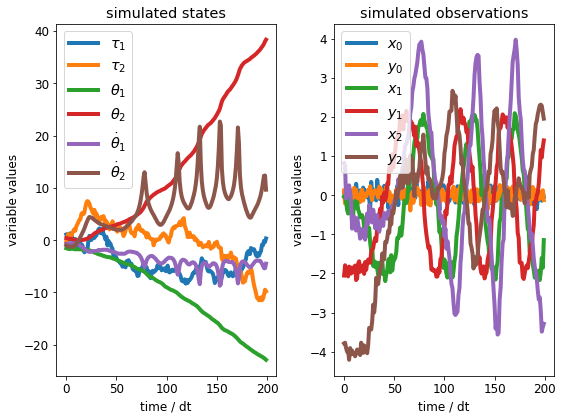

In [23]:
ind_in_batch = 8
plot_simulated_data(lat_data_np, 
                        sim_data_np, 
                        ind_in_batch,
                        label_dict_full,
                       plot_folder + '/sim_dataset.png')

In [24]:
inference_result = infer_latents(full_model, 
                                 sim_observs, 
                                 num_particles)

run time for 200 timesteps, 16 batches, 1000 particles = 24.62


In [25]:
# summarize posterior separately for each batch element.
# if batches are identical, each includes an independent SMC sample
posterior_summary = utils_summary.summarize_posterior(inference_result)

applying uniform average of 16 SMC samplers.
applying weighted average of 16 SMC samplers.


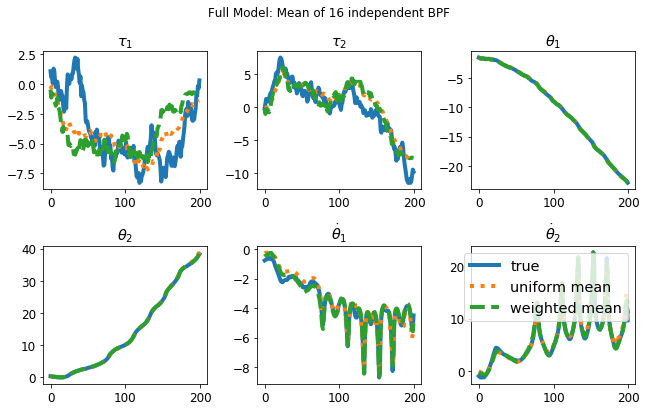

In [26]:
# comparison of uniform and weighted means
# uniform:
mean, var = utils_summary.summarize_independent_smc_samplers(
    posterior_summary["smooth_mean"],
    posterior_summary["smooth_var"],
    logw=None,
    method='uniform')
# weighted:
weighted_mean, weighted_var = utils_summary.summarize_independent_smc_samplers(
    posterior_summary["smooth_mean"],
    posterior_summary["smooth_var"],
    logw=inference_result["log_marginal_likelihood"].detach().numpy(),
    method='weighted',
    remove_indices=None)  # typically better to remove 1/2 dominating indices

# plot the two estimates.
f, axarr = plt.subplots(2, 3, figsize=(9, 6))
axarr = axarr.flatten()
for i in range(lat_data_np.shape[1]):
    axarr[i].plot(lat_data_np[0, i, :], label='true')
    axarr[i].plot(mean[i, :], linestyle='dotted', label='uniform mean')
    axarr[i].plot(weighted_mean[i, :],
                  linestyle='dashed',
                  label='weighted mean')
    axarr[i].set_title(label_dict_full["state"][i])
    if i == lat_data_np.shape[1] - 1:
        plt.legend()
f.suptitle('Full Model: Mean of %i independent BPF' % batch_size)
f.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(plot_folder + '/mean_of_64_filters_grav.png')

(array([1]),)


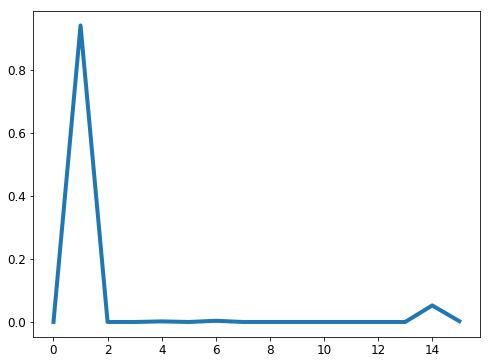

In [34]:
from scipy.special import logsumexp
logw = inference_result["log_marginal_likelihood"].detach().numpy()
w = np.exp(logw - logsumexp(logw))
plt.plot(w)
print(np.where(w==np.max(w)))

In [35]:
np.sort(w) # note that many some w's are == 0. check that in future.

array([0.00000000e+000, 0.00000000e+000, 1.03759465e-174, 2.46830938e-078,
       1.02296611e-038, 2.05069265e-011, 2.14282796e-011, 1.14377528e-009,
       1.74238871e-009, 9.05019274e-009, 1.96338314e-006, 1.82345909e-003,
       2.48157996e-003, 3.73536901e-003, 5.24154694e-002, 9.39542147e-001])

In [36]:
#np.where(w==0)
#np.where(np.isin(w, np.sort(w)[-2:])) # which are the two best filters
#np.where(~np.isin(w, np.sort(w)[-2:])) # worst filters

/anaconda3/envs/pytorch_env/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()


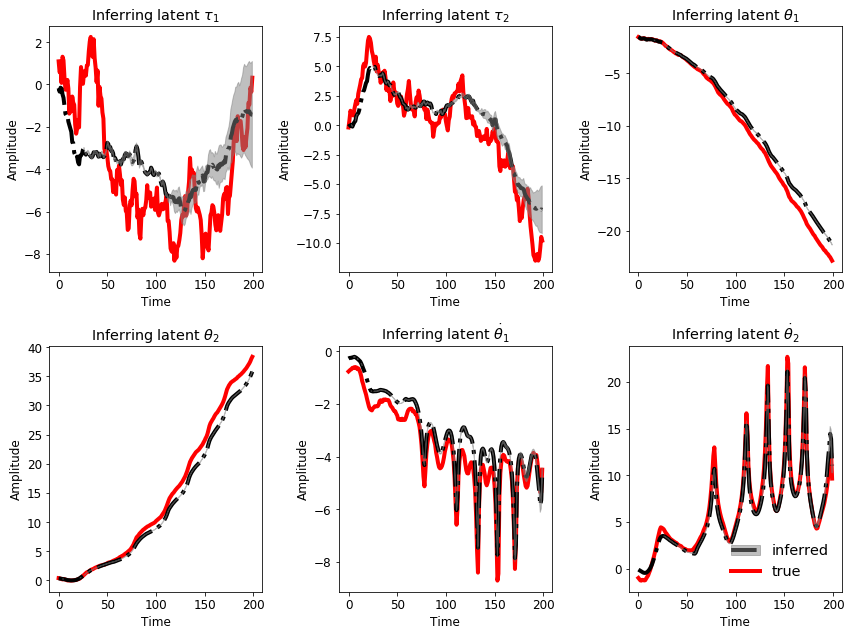

In [37]:
# another version of the plot, incorporating variances.
fig_full_path = plot_folder + '/uniform.png'
nrows = 2
num_latents = lat_data_np.shape[1]
fig, axs = plt.subplots(nrows,
                        int(num_latents / nrows),
                        figsize=(12, 9),
                        sharey=False)
axs = axs.flatten()
plt_leg = False
for i in range(mean.shape[0]):
    if i == num_latents-1:
        plt_leg = True
    arm_utils.plot_posterior_trace(
    post_mean=mean[i,:],
    post_var=np.sqrt(var[i,:]),
    data_vec=lat_data_np[ind_in_batch, i, :],
    alpha=0.5,
    plot_legend=plt_leg,
    plot_uncertainty=True,
    plot_true_data=True,
    legends_list=["inferred", "true"],
    legend_loc="lower right",
    title="Inferring latent " + label_dict_full["state"][i],
    xlabel='Time',
    ylabel='Amplitude',
    fig_fullname=None,
    ax=axs[i])
fig.tight_layout()
plt.savefig(fig_full_path)

/anaconda3/envs/pytorch_env/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()


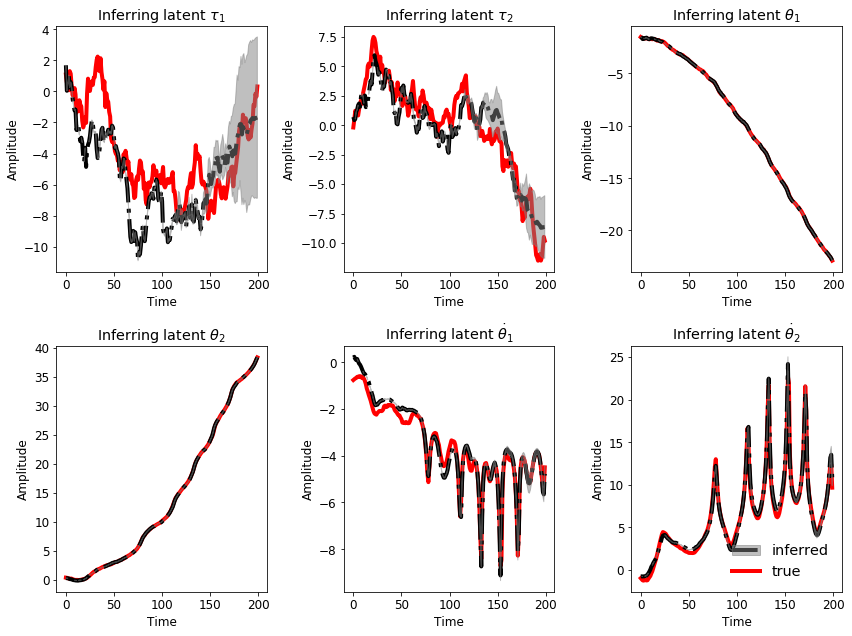

In [38]:
# another version of the plot, incorporating variances.
fig_full_path = plot_folder + '/weighted.png'
nrows = 2
num_latents = lat_data_np.shape[1]
fig, axs = plt.subplots(nrows,
                        int(num_latents / nrows),
                        figsize=(12, 9),
                        sharey=False)
axs = axs.flatten()
plt_leg = False
for i in range(weighted_mean.shape[0]):
    if i == num_latents-1:
        plt_leg = True
    arm_utils.plot_posterior_trace(
    post_mean=weighted_mean[i,:],
    post_var=np.sqrt(weighted_var[i,:]),
    data_vec=lat_data_np[ind_in_batch, i, :],
    alpha=0.5,
    plot_legend=plt_leg,
    plot_uncertainty=True,
    plot_true_data=True,
    legends_list=["inferred", "true"],
    legend_loc="lower right",
    title="Inferring latent " + label_dict_full["state"][i],
    xlabel='Time',
    ylabel='Amplitude',
    fig_fullname=None,
    ax=axs[i])
fig.tight_layout()
plt.savefig(fig_full_path)

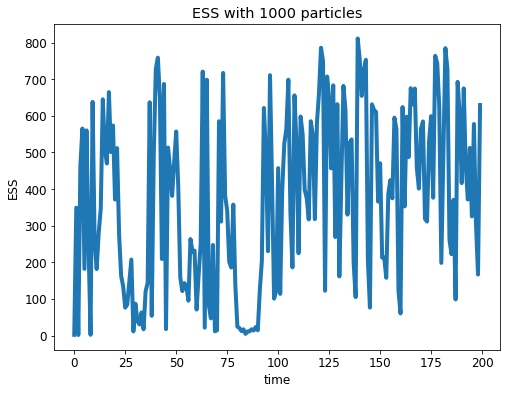

In [39]:
# plot ESS
plt.plot(posterior_summary["ESS"][ind_in_batch,:])
plt.xlabel('time')
plt.ylabel('ESS')
plt.title('ESS with %i particles' % num_particles);
plt.savefig(plot_folder+'/ESS_1.png')

In [40]:
## if simulate all the way forward to coords.
#x_obs = sim_data_np[ind_in_batch, [0,2,4], :].T
#y_obs = sim_data_np[ind_in_batch, [1,3,5], :].T
## if simulate only to angles and velocities.
x_obs, y_obs = arm_utils.coords_from_params_mat(
   lat_data_np[ind_in_batch,2,:], 
    lat_data_np[ind_in_batch,3,:], 
                inits_dict["L1"], inits_dict["L2"]) 
print(y_obs.shape)

(200, 3)


In [42]:
# TODO: make sure to input right params for learning
# this is the version for weighted average of BPFs
x_hat , y_hat = arm_utils.coords_from_params_mat(
   weighted_mean[2,:], 
    weighted_mean[3,:], 
                inits_dict["L1"], inits_dict["L2"]) 
x_hat.shape

(200, 3)

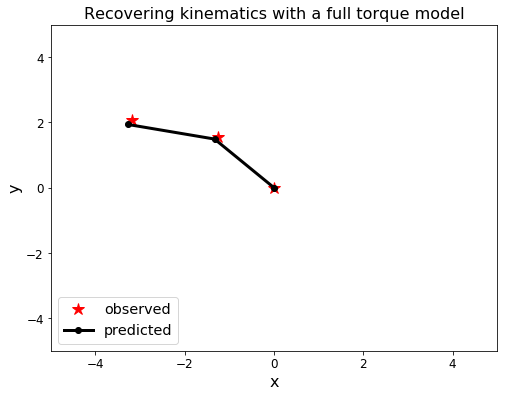

In [59]:
arm_utils.video_sim_plane_2D(x_obs, y_obs, 
                             x_hat, y_hat, 
                             plot_folder+'/recover_dyn', 
                   "Recovering kinematics with a full torque model", 
                             x_hat.shape[0], inits_dict["L1"] + 
                             inits_dict["L2"] + 1)

In [30]:
# tested with functions. it works.
# ToDo: consider building a class that does that.
# give it the inference results and desired K realizations and it'll
# do everything.

k_realizations = 50
smoothing_result = {}  # dict of lists
smoothing_result["normalized_weights"] = []
smoothing_result["latents"] = []
smoothing_result["sampled_indices"] = []

for t in range(num_timesteps - 1, -1, -1):
    if t == num_timesteps - 1:
        normalized_weights = smoothing.expand_normalize_weights(
            inference_result["log_weights"][-1],
            k_realizations)  # Note index -1
        sampled_indices, latents = smoothing.sample_latents(
            normalized_weights, inference_result["latents"][-1])
    else:
        # compute weights
        normalized_weights = smoothing.weight_update(latents,
                                           inference_result["latents"][t],
                                           inference_result["log_weights"][t],
                                           full_model["transition"])

        sampled_indices, latents = smoothing.sample_latents(
            normalized_weights, inference_result["latents"][t])

    # these lists will all be flipped in time
    smoothing_result["normalized_weights"].append(normalized_weights)
    smoothing_result["latents"].append(latents)
    smoothing_result["sampled_indices"].append(sampled_indices)

In [31]:
# flip order
smoothing_result["normalized_weights"] = smoothing_result["normalized_weights"][::-1]
smoothing_result["latents"] = smoothing_result["latents"][::-1]
smoothing_result["sampled_indices"] = smoothing_result["sampled_indices"][::-1]

In [32]:
smoothing_result["latents"][-1].shape
posterior_summary["smooth_mean"].shape

(16, 6, 200)

In [33]:
smooth_traj = torch.cat(
    [smooth.unsqueeze(-1) for smooth in smoothing_result["latents"]], dim=3)
smooth_mean = torch.mean(smooth_traj,
                         dim=0).detach().numpy()  # over trajectories
smooth_var = torch.var(smooth_traj, dim=0).detach().numpy()

In [34]:
smooth_mean.shape
smooth_var.shape

(16, 6, 200)

In [35]:
# if batch elements are identical, take a uniform mean
mean, var = summarize_independent_smc_samplers(
    smooth_mean,
    smooth_var,
    logw=None,
    method='uniform')

applying uniform average of 16 SMC samplers.


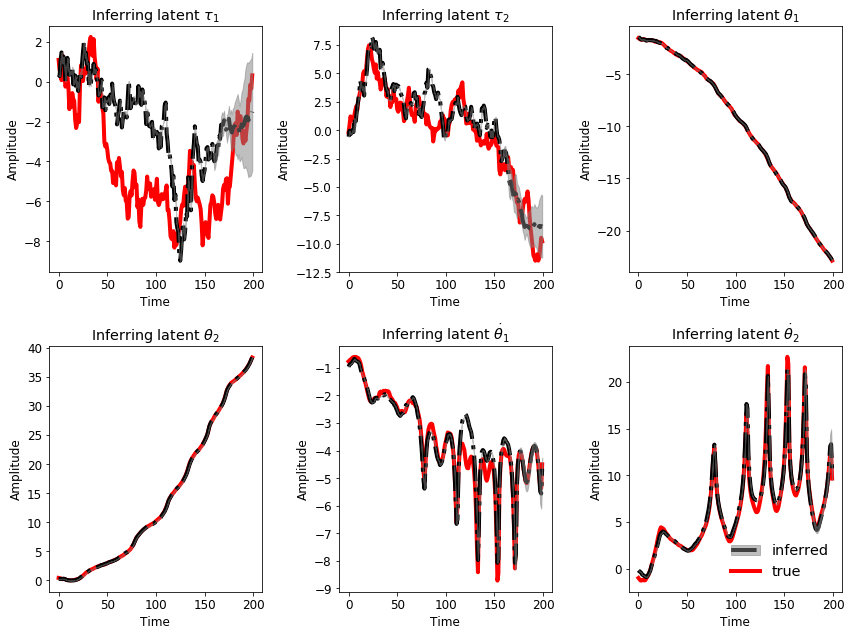

In [36]:
ind_in_batch = 6  # just one batch
fig, axs = plt.subplots(2, 3, figsize=(12, 9), sharey=False)
axs = axs.flatten()
plt_leg = False
for i in range(posterior_summary["smooth_mean"].shape[1]):
    if i == 5:
        plt_leg = True
    arm_utils.plot_posterior_trace(
        post_mean=smooth_mean[ind_in_batch, i, :],
        post_var=np.sqrt(smooth_var[ind_in_batch, i, :]),
        data_vec=lat_data_np[ind_in_batch, i, :],
        alpha=0.5,
        plot_legend=plt_leg,
        plot_uncertainty=True,
        plot_true_data=True,
        legends_list=["inferred", "true"],
        legend_loc="lower right",
        title="Inferring latent " + label_dict_full["state"][i],
        xlabel='Time',
        ylabel='Amplitude',
        fig_fullname=None,
        ax=axs[i])
fig.tight_layout()
plt.savefig(plot_folder + '/FFBS_BPF_infer_latents.png')

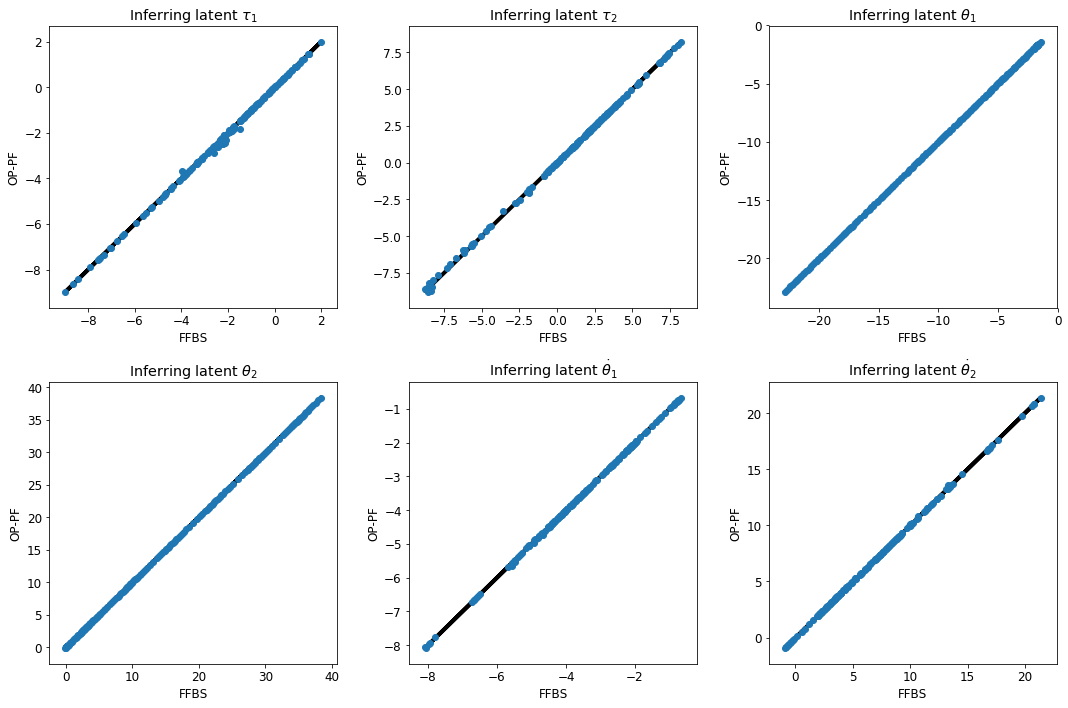

In [38]:
titles = ['$x_{1}$', '$x_{2}$']
plt_leg = False
nrows = 2
fig, axs = plt.subplots(nrows,int(posterior_summary["smooth_mean"].shape[1]/nrows), 
                        figsize = (15,10), sharey=False)
axs = axs.flatten()
for i in range(posterior_summary["smooth_mean"].shape[1]):
    
    if i == 0:
        label = '$x_{1} = f$'
    elif i == 1:
        label = '$x_{2} = x$'
    elif i == 2:
        label = '$x_{3} = \dot{x}$'
        plt_leg = True
    
    axs[i].plot(smooth_mean[ind_in_batch,i,:], 
                smooth_mean[ind_in_batch,i,:], 'k') # diag line
    axs[i].scatter(smooth_mean[ind_in_batch,i,:], 
            posterior_summary["smooth_mean"][ind_in_batch,i,:], 
                   zorder=3)
    axs[i].set_xlabel('FFBS')
    axs[i].set_ylabel('OP-PF')
#     axs[i].plot(filtered_state_means[:,i], color = 'black', linestyle = 'dotted', 
#                 label = 'Kalman filter');
    axs[i].set_title("Inferring latent " +  label_dict_full["state"][i])

fig.tight_layout()
plt.savefig(plot_folder+'/compare_FFBS_BPF.png')

Implement learning of $M_1$ and $M_2$

In [29]:
sim_data_np.shape

(16, 6, 200)

In [35]:
sim_data_np[0, :2, :]

array([[ 5.70418582e-02, -1.26147187e-01,  7.33463124e-02,
        -1.06593631e-03,  2.47888052e-02, -2.22029565e-01,
        -8.18543951e-02, -2.51541028e-01, -8.01100919e-02,
        -2.31288582e-02, -7.02392525e-02, -1.77268907e-01,
         2.89053106e-01,  1.63828490e-02, -1.90669266e-01,
         7.54882909e-02,  1.19438432e-01,  2.13900395e-02,
         3.19796050e-02,  1.90996601e-01,  1.32161615e-01,
         1.18693354e-01,  4.96322846e-02, -5.77234386e-02,
         5.99473435e-02, -7.47436410e-02, -3.49145487e-01,
         3.36627451e-01,  2.93188017e-02,  1.38095598e-01,
         7.88760159e-02, -1.46822371e-02, -1.35461429e-01,
         3.88674974e-01,  1.61835988e-01, -8.74782858e-02,
         1.82245095e-01, -1.15807996e-01, -1.59490798e-01,
        -1.74081084e-01,  2.35196582e-01,  1.15926201e-04,
        -3.71860548e-02,  2.13730724e-01, -3.26950107e-01,
        -1.16073656e-01, -1.65290985e-01, -5.48096284e-02,
        -1.08871898e-01, -2.64580158e-01, -7.58570321e-0

In [44]:
empirical_estimate_L1 = np.linalg.norm(sim_data_np[0, 2:4, :] - sim_data_np[0, :2, :], axis=0)
empirical_estimate_L2 = np.linalg.norm(sim_data_np[0, 4:, :] - sim_data_np[0, 2:4, :], axis=0)

In [48]:
(inits_dict["L1"] - np.median(empirical_estimate_L1)) / inits_dict["L1"]

-0.003617780302634266

In [49]:
(inits_dict["L2"] - np.median(empirical_estimate_L2)) / inits_dict["L2"]

-0.009406472491689799

In [52]:
# look at fw kin learning script for variables, etc.

2.0

In [28]:
learning_inits_dict = {}
learning_inits_dict['L1'] =  inits_dict["L1"] # for now, can be empirical estimate or learned
learning_inits_dict['L2'] = inits_dict["L1"] # same
learning_inits_dict['M1'] = 0.7 # test init for true == 1.1
learning_inits_dict['M2'] = 1.5 # test init for true == 1.1

In [29]:
arm_model_learning = planar_arm_dyn_model.PlanarArmDyn(
    dt=dt,
    inits_dict=learning_inits_dict,
    g=g,
    include_gravity_fictitious=True,
    transform_torques=False,
    learn_static= True)

In [30]:
list(arm_model_learning.parameters())

[Parameter containing:
 tensor(0.7000, requires_grad=True),
 Parameter containing:
 tensor(1.5000, requires_grad=True)]

In [23]:
param_dict
# ToDo: there are more params you can add to param dict?

{'init_mu': array([0., 0., 0., 0., 0., 0.]),
 'init_cov': array([[0.5, 0. , 0. , 0. , 0. , 0. ],
        [0. , 0.5, 0. , 0. , 0. , 0. ],
        [0. , 0. , 0.5, 0. , 0. , 0. ],
        [0. , 0. , 0. , 0.5, 0. , 0. ],
        [0. , 0. , 0. , 0. , 0.5, 0. ],
        [0. , 0. , 0. , 0. , 0. , 0.5]])}

In [31]:
learning_model = {}
'''full_model includes arm dynamics, and FW-KIN emission.
here we learn M1 and M2'''

learning_model["initial"] = planar_arm_dyn_model.Initial(param_dict["init_mu"],
                                                     param_dict["init_cov"])

learning_model["transition"] = planar_arm_dyn_model.Transition(
    dt, transition_force_scale, transition_aux_scale, arm_model_learning)

learning_model["emission"] = planar_arm_dyn_model.Emission(learning_inits_dict,
                                                       np.eye(6) *
                                                       emission_var_diag,
                                                       theta_indices=[2, 3])

learning_model["proposal"] = planar_arm_dyn_model.Bootstrap_Proposal( \
                               learning_model["initial"], learning_model["transition"])

In [40]:
batch_size = 2
dataloader = train.get_synthetic_dataloader(
            full_model["initial"],
            full_model["transition"],
            full_model["emission"],
            num_timesteps, batch_size)

In [41]:
# ToDo: look at the aesmc original script for training
training_stats = planar_arm_dyn_model.TrainingStats(
                M1_true = inits_dict["M1"], 
                M2_true = inits_dict["M2"],
                num_timesteps = num_timesteps,
                logging_interval = logging_interval)

In [42]:
list(learning_model["transition"].parameters())

[Parameter containing:
 tensor(0.6968, requires_grad=True),
 Parameter containing:
 tensor(1.4969, requires_grad=True)]

In [43]:
train.train(dataloader=dataloader,
            num_particles=num_particles,
            algorithm='aesmc',
            initial=learning_model["initial"],
            transition=learning_model["transition"],
            emission=learning_model["emission"],
            proposal=learning_model["proposal"],
            num_epochs=1,
            num_iterations_per_epoch=num_iterations,
            callback=training_stats)

each batch contains different data.
Iteration 0: Loss = 4250.039099827667
each batch contains different data.
each batch contains different data.
each batch contains different data.
each batch contains different data.
each batch contains different data.
each batch contains different data.
each batch contains different data.
each batch contains different data.
each batch contains different data.
each batch contains different data.
Iteration 10: Loss = 5454.511490183001
each batch contains different data.
each batch contains different data.
each batch contains different data.
each batch contains different data.
each batch contains different data.
each batch contains different data.
each batch contains different data.
each batch contains different data.
each batch contains different data.
each batch contains different data.
Iteration 20: Loss = -131.1342538962314
each batch contains different data.
each batch contains different data.
each batch contains different data.
each batch contains

each batch contains different data.
each batch contains different data.
each batch contains different data.
each batch contains different data.
each batch contains different data.
each batch contains different data.
Iteration 210: Loss = -442.83113012208617
each batch contains different data.
each batch contains different data.
each batch contains different data.
each batch contains different data.
each batch contains different data.
each batch contains different data.
each batch contains different data.
each batch contains different data.
each batch contains different data.
each batch contains different data.
Iteration 220: Loss = 21036.46255674061
each batch contains different data.
each batch contains different data.
each batch contains different data.
each batch contains different data.
each batch contains different data.
each batch contains different data.
each batch contains different data.
each batch contains different data.
each batch contains different data.
each batch contain

each batch contains different data.
Iteration 410: Loss = 13707.046663027775
each batch contains different data.
each batch contains different data.
each batch contains different data.
each batch contains different data.
each batch contains different data.
each batch contains different data.
each batch contains different data.
each batch contains different data.
each batch contains different data.
each batch contains different data.
Iteration 420: Loss = -404.63223469875925
each batch contains different data.
each batch contains different data.
each batch contains different data.
each batch contains different data.
each batch contains different data.
each batch contains different data.
each batch contains different data.
each batch contains different data.
each batch contains different data.
each batch contains different data.
Iteration 430: Loss = -467.5179610119284
each batch contains different data.
each batch contains different data.
each batch contains different data.
each batch c

In [45]:
training_stats.curr_M2

[1.4988552331924438,
 1.4916211366653442,
 1.494787573814392,
 1.4985477924346924,
 1.506210207939148,
 1.5097321271896362,
 1.5102081298828125,
 1.5102792978286743,
 1.5101990699768066,
 1.5102699995040894,
 1.5097929239273071,
 1.5092384815216064,
 1.509225606918335,
 1.5093327760696411,
 1.5093618631362915,
 1.5093563795089722,
 1.5085653066635132,
 1.5083667039871216,
 1.5082590579986572,
 1.5082224607467651,
 1.5082204341888428,
 1.5082088708877563,
 1.5082063674926758,
 1.5061241388320923,
 1.493869662284851,
 1.4807994365692139,
 1.4791717529296875,
 1.4937736988067627,
 1.4969490766525269,
 1.497344732284546,
 1.4887745380401611,
 1.4875359535217285,
 1.498012661933899,
 1.5034757852554321,
 1.5040820837020874,
 1.504150629043579,
 1.5041592121124268,
 1.504162311553955,
 1.5041710138320923,
 1.5041722059249878,
 1.5042166709899902,
 1.5046077966690063,
 1.5129328966140747,
 1.5143365859985352,
 1.5144723653793335,
 1.4987047910690308,
 1.4928017854690552,
 1.4920682907104492,


In [26]:
list(arm_model_learning.parameters())

AttributeError: 'PlanarArmDyn' object has no attribute 'parameters'